In [1]:
import os
import sys
here = os.getcwd()
sys.path.append(os.path.join(here,"../../"))

import warnings
warnings.filterwarnings("ignore")


import numpy as np
import random
import seaborn as sns
import amore.explainer.rule_pattern_miner as rlm
import amore.explainer.DT_rules as dtr
import amore.explainer.explainer_utils as eutils

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Linear
from torch_geometric.nn import GraphConv
from torch_geometric.nn import global_mean_pool
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, export_text

from rdkit import Chem
from rdkit.Chem import Descriptors

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [2]:
def recover_feature_raw_value(fid,fval,featur_names,raw_min_max,ntype="min_max"):
    fn = featur_names[fid]
    if ntype == "min_max":
        if fn in raw_min_max.columns:
            mx = raw_min_max.loc[:,fn].max()
            mi = raw_min_max.loc[:,fn].min()
            return fval*(mx-mi)+mi
        return fval
    else:
        raise TypeError("Not yet supported type")

In [3]:
## Control randomness for reproducibility

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 1. Data loading and preprocessing

### 1.1 Load the data into graph

In [4]:
from torch_geometric.datasets import MoleculeNet
dataset = MoleculeNet(root='./data/MoleculeNet', name='Tox21')
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Tox21(7831):
Number of graphs: 7831
Number of features: 9
Number of classes: 12


### 1.2 Transform SMILES to RDKit descriptors

In [5]:
def calculate_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Handle invalid SMILES input

    descriptor_name = []; value_list = []
    for name, descriptor_function in Descriptors.descList:
        value = descriptor_function(mol)
        value_list.append(value)
        descriptor_name.append(name)

    return value_list, descriptor_name

def smiles_to_rdkit(dataset):
    rdk_features = []
    for i in range(len(dataset)):
        smiles = dataset[i].smiles
        features, descriptors = calculate_all_descriptors(smiles)
        rdk_features.append(features)

    return torch.tensor(rdk_features, dtype=torch.float32), descriptors

### 1.3 Divide the data into training validatiton and testing

In [6]:
dataset = dataset.shuffle()

train_dataset = dataset[:int(len(dataset) * 0.7)]
val_dataset = dataset[int(len(dataset) * 0.7):int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8):]

## generate rdk descriptors from smiles representation of molecules
dataset_rdk, descriptors = smiles_to_rdkit(dataset)
## remove descriptors with nan values
descriptors = [descriptors[i] for i in range(len(descriptors)) if ~torch.any(dataset_rdk.isnan(), dim=0)[i]]
dataset_rdk = dataset_rdk[:,~torch.any(dataset_rdk.isnan(), dim=0)]
dataset_rdk = (dataset_rdk - dataset_rdk.mean(axis=0))/dataset_rdk.std(axis=0) ## normalize
descriptors = [descriptors[i] for i in range(len(descriptors)) if ~torch.any(dataset_rdk.isnan(), dim=0)[i]]
dataset_rdk = dataset_rdk[:,~torch.any(dataset_rdk.isnan(), dim=0)]

train_dataset_rdk = dataset_rdk[:int(len(dataset_rdk) * 0.7)]
val_dataset_rdk = dataset_rdk[int(len(dataset_rdk) * 0.7):int(len(dataset_rdk) * 0.8)]
test_dataset_rdk = dataset_rdk[int(len(dataset_rdk) * 0.8):]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

## task weights for training
mask = 1-torch.isnan(train_dataset.y).type(torch.float32)
task_weight = 1 / torch.mean(mask, axis = 0)
label_weight = torch.sum(train_dataset.y == 0., axis = 0) / torch.sum(train_dataset.y == 1., axis = 0) 

[17:27:18] WARNING: not removing hydrogen atom without neighbors
[17:27:18] WARNING: not removing hydrogen atom without neighbors
[17:27:18] WARNING: not removing hydrogen atom without neighbors


Number of training graphs: 5481
Number of validation graphs: 783
Number of test graphs: 1567


## 2. GNN model

In [7]:
batch_size = 64; learning_rate=0.001; num_epoch=200

In [8]:


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        self.activation_fn_last = nn.Sigmoid()


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.activation_fn_last(self.lin(x))

        return x

class GNNtraining(object):
    def __init__(self, 
                 model, 
                 learning_rate=0.001, 
                 num_epoch=200,
                 use_cuda=False):
        
        self.model = model
        self.learning_rate = learning_rate
        self.num_epoch = num_epoch
        
        self.use_cuda = use_cuda
        if use_cuda:
            self.model.cuda()
        
    def training(self, train_loader, val_loader, task_weight, label_weight):     
        parameters = set(self.model.parameters())
        optimizer = optim.Adam(parameters, lr=self.learning_rate, eps=1e-3)

        for epoch in range(self.num_epoch):
            for data in train_loader:
                y_batch = torch.nan_to_num(data.y, nan=0.0) # nan to 0.0
                
                task_weight_batch = ~data.y.isnan()*task_weight # weight each task according to the number of valid labels
                label_weight_batch = y_batch * label_weight; label_weight_batch[label_weight_batch==0.0] = 1.0 # weight each label according to the number of positive labels
                w_batch = task_weight_batch * label_weight_batch
                if self.use_cuda:
                    data = data.cuda(); y_batch = y_batch.cuda(); w_batch = w_batch.cuda()
                criterion = nn.BCELoss(weight=w_batch)
                optimizer.zero_grad()
                self.model.train()
                # calculate the training loss
                output = self.model(data.x.to(torch.float32), data.edge_index, data.batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            train_bce = loss.detach()
            train_acc = self.evaluation(train_loader)
            val_acc = self.evaluation(val_loader)
            print('>>> Epoch {:5d}/{:5d} | train_bce={:.5f} | train_acc={:.5f} | val_acc={:.5f}'.format(epoch, self.num_epoch, train_bce, train_acc, val_acc))
                
    def evaluation(self, loader):
        self.model.eval()
        correct = 0; total = 0
        for data in loader:
            if self.use_cuda:
                data = data.cuda()
            output = self.model(data.x.to(torch.float32), data.edge_index, data.batch)
            pred = (output > 0.5).to(torch.float32)
            correct += int((pred == data.y).sum())
            total += int((~data.y.isnan()).sum())

        return correct/total


In [9]:
from torch_geometric.loader import DataLoader as GDataLoader

torch.manual_seed(seed)
train_loader = GDataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = GDataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
torch.manual_seed(seed)
gnn = GNN(hidden_channels=64)

## If train the model from scratch, change it a non-existing path 
model_path = 'gnn_models/gnn.pt' 

if os.path.exists(model_path):
    gnn.load_state_dict(torch.load(model_path))
else:
    gnn_training = GNNtraining(gnn, learning_rate, num_epoch, use_cuda=False)
    gnn_training.training(train_loader, val_loader, task_weight, label_weight)
    torch.save(gnn.state_dict(), model_path)



## 3. Interpretation

In [11]:


train_loader_visualization = GDataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
for train_data in train_loader_visualization:
    break
for val_data in val_loader:
    break
train_loader_rdk_visualization = DataLoader(TensorDataset(train_dataset_rdk, train_dataset.y), batch_size=len(train_dataset_rdk), shuffle=False)
for train_data_x, train_data_y in train_loader_rdk_visualization:
    break

y_pred_s_gnn = gnn(train_data.x.to(torch.float32), train_data.edge_index, train_data.batch).detach().numpy()

y_pred_test_gnn = gnn(val_data.x.to(torch.float32), val_data.edge_index, val_data.batch).detach().numpy()


## 3.1 Task1 -- AR

In [12]:
idx_task = 0

y_true = train_data.y.numpy()[:,idx_task:idx_task+1].reshape(-1); idx = ~np.isnan(y_true)
y_pred_s = y_pred_s_gnn[:,idx_task:idx_task+1].reshape(-1)[idx]
y_true = y_true[idx].astype(int)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_s)
th_id = np.argmax(tpr - fpr); y_thd = thresholds[th_id]

fids = [i for i in range(len(descriptors))]
feature_types = []
for i in range(len(descriptors)):
    c = descriptors[i]
    if np.dtype(train_data_x.numpy()[idx][:,i][0])!=np.uint8:
        feature_types.append(str(np.dtype(train_data_x.numpy()[idx][:,i][0])))
    else:
        feature_types.append("cat")
    # print(c,np.dtype(train_data_x.numpy()[idx][:,i][0]),feature_types[-1])

y_true_test = val_data.y.numpy()[:,idx_task:idx_task+1].reshape(-1); idx_test = ~np.isnan(y_true_test)
y_pred_test = y_pred_test_gnn[:,idx_task:idx_task+1].reshape(-1)[idx_test]
y_true_test = y_true_test[idx_test].astype(int)

print('Task {}: total positive: {:}; total predictived positive:{:}; recall:{:.5f}; precision:{:.5f}; auroc: {:.5f}; test auroc:  {:.5f}'.format(idx_task, sum(y_true), sum(y_pred_s>y_thd), recall_score(y_true, y_pred_s>y_thd), precision_score(y_true, y_pred_s>y_thd), roc_auc_score(y_true, y_pred_s), roc_auc_score(y_true_test, y_pred_test)))


Task 0: total positive: 219; total predictived positive:834; recall:0.73059; precision:0.19185; auroc: 0.88678; test auroc:  0.57895


In [13]:
## set "grid_search = True" to do a grid search for hyperprameters

grid_search = True

if grid_search:
    ng_range = np.arange(2,11)
    bin_strategies = ["uniform","kmeans"]
    support_range = np.arange(100,800,100)
    confidence_lower_bound = 0.8
    max_depth=2
    top_K=3


    best_rule_set,best_configs,config_metric_records = rlm.param_grid_search_for_amore(bin_strategies,ng_range,support_range,train_data_x.numpy()[idx],fids,target_indices=y_pred_s>y_thd,y=y_true,c=1,confidence_lower_bound = confidence_lower_bound,
                                                                                        max_depth=max_depth,top_K=top_K,sort_by="fitness")
    print(best_rule_set,best_configs)

grid search hyperparameters
{'rules': [(95, '>=', 1.1488014), (95, '<=', 10.405089), (52, '>=', 0.16672002)], 'confidence': 0.8006134969325154, 'support': 326, 'fitness': 0.2350119904076739, 'cond_prob_y': 0.34355828220858897, 'ratio_y': 0.5114155251141552} {'bin_strategy': 'kmeans', 'num_grids': 3, 'min_support': 300}


In [14]:
### search rules for target pattern: pred_y > y_thd  ###
### we set the hyperparameters obtaind by above grid search step ###
min_support=300
num_grids=3
max_depth=2
bin_strategy="kmeans"
top_K = 3

y_rule_candidates = rlm.gen_rule_list_for_one_target(train_data_x.numpy()[idx],fids,y_pred_s>y_thd,y=y_true,c=1,sort_by="fitness",
                                                    min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=top_K,
                                                    local_x=None,bin_strategy=bin_strategy,
                                                    verbose=False,search="greedy")
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],descriptors)
    y_rule_candidates[i] = rules
    
y_rule_candidates

[{'rules': [(95, 'NumAliphaticRings', '>=', 1.1488014),
   (95, 'NumAliphaticRings', '<=', 10.405089),
   (52, 'SMR_VSA5', '>=', 0.16672008)],
  'confidence': 0.8006134969325154,
  'support': 326,
  'fitness': 0.2350119904076739,
  'cond_prob_y': 0.34355828220858897,
  'ratio_y': 0.5114155251141552},
 {'rules': [(95, 'NumAliphaticRings', '>=', 1.1488014),
   (95, 'NumAliphaticRings', '<=', 10.405089),
   (16, 'Chi0', '>=', 0.065092266)],
  'confidence': 0.7689969604863222,
  'support': 329,
  'fitness': 0.2122302158273381,
  'cond_prob_y': 0.3282674772036474,
  'ratio_y': 0.4931506849315068},
 {'rules': [(95, 'NumAliphaticRings', '>=', 1.1488014),
   (95, 'NumAliphaticRings', '<=', 10.405089),
   (124, 'fr_NH0', '<=', 0.5092024)],
  'confidence': 0.7731629392971247,
  'support': 313,
  'fitness': 0.2050359712230216,
  'cond_prob_y': 0.3514376996805112,
  'ratio_y': 0.502283105022831},
 {'rules': [(26, 'Chi4n', '>=', 1.6014602),
   (12, 'FpDensityMorgan3', '>=', -0.9372277)],
  'confide

In [15]:
## set "grid_search = True" to do a grid search for hyperprameters

if grid_search:
    criteria = ["gini", "entropy", "log_loss"]; c=1.
    w = (y_true==c).sum()/y_true.shape[0]
    # class_weight_options = [{0:0.5,1:0.5},{0:1./(1.-w),1:1./w}]
    class_weight_options = [{0:0.5,1:0.5},'balanced']
    support_range = np.arange(100,800,100)
    
    ## If no any rule sets above 0.8, set it to 0. to simply select by fitness
    confidence_lower_bound = 0.8 
    max_depth=2
    DT_best_rule_set, DT_best_configs, DT_config_metric_records = dtr.param_grid_search_for_DT(criteria,support_range,weight_options=class_weight_options,X=train_data_x.numpy()[idx],y=y_true,target_indices=y_pred_s>y_thd,c=1,max_depth=max_depth,feature_names=descriptors,confidence_lower_bound=confidence_lower_bound,seed=seed)
    print(DT_best_rule_set, DT_best_configs)


{'rules': [(95, '>', 1.414), (52, '>', 0.836)], 'support': 253, 'fitness': 0.22661870503597123, 'confidence': 0.8735177865612648} {'criterion': 'gini', 'min_support': 100, 'class_weight': {0: 0.5, 1: 0.5}}


In [16]:
### Obtain rules for target pattern: pred_y > y_thd from a DecisionTreeClassifier ###
### We set the hyperparameters obtaind by above grid search step ###
criterion="gini"
min_support=100
class_weight={0: 0.5, 1: 0.5}

input_feature_names =descriptors
treemodel = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_support,criterion=criterion,random_state=seed,class_weight=class_weight)
treemodel.fit(train_data_x.numpy()[idx],y_pred_s>y_thd)
rule_list, rule_value_list, rule_metric_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,train_data_x.numpy()[idx],y_true,y_pred_s>y_thd,np.arange(train_data_x.numpy()[idx].shape[-1]),descriptors,c=1)
print(export_text(treemodel))

## display rules extracted by DT classifier
dtr.display_rules_from_DT(rule_list,rule_metric_list,input_feature_names)

|--- feature_95 <= 1.41
|   |--- feature_145 <= 0.70
|   |   |--- class: False
|   |--- feature_145 >  0.70
|   |   |--- class: False
|--- feature_95 >  1.41
|   |--- feature_52 <= 0.84
|   |   |--- class: False
|   |--- feature_52 >  0.84
|   |   |--- class: True

#################
[(95, '<=', 1.414), (145, '<=', 0.698)]
confidence 0.097 cond_prob_y 0.019 support 4380 fitness -4.235
NumAliphaticRings <= 1.414
fr_bicyclic <= 0.698
#################
[(95, '<=', 1.414), (145, '>', 0.698)]
confidence 0.431 cond_prob_y 0.058 support 311 fitness -0.052
NumAliphaticRings <= 1.414
fr_bicyclic > 0.698
#################
[(95, '>', 1.414), (52, '<=', 0.836)]
confidence 0.407 cond_prob_y 0.096 support 135 fitness -0.03
NumAliphaticRings > 1.414
SMR_VSA5 <= 0.836
#################
[(95, '>', 1.414), (52, '>', 0.836)]
confidence 0.874 cond_prob_y 0.407 support 253 fitness 0.227
NumAliphaticRings > 1.414
SMR_VSA5 > 0.836


### Task1 AR: fitness and confidence with different minimum support

In [17]:
confidence_lower_bound = 0.9
confidence_lower_bound

0.9

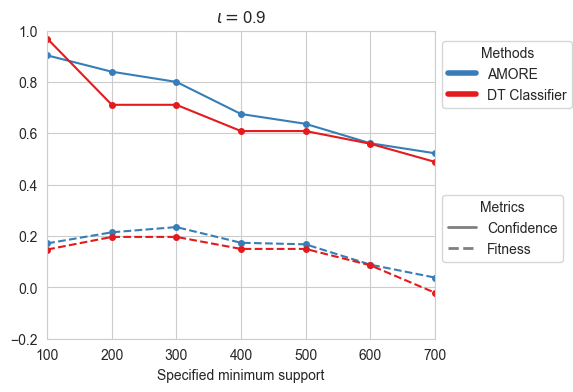

In [18]:
## Need grid search first to get the results with different minimum supports

if grid_search:
    
    cf_mtx = np.vstack([config_metric_records[key]["top_confidence_records"] for key in config_metric_records.keys()])
    ft_mtx = np.vstack([config_metric_records[key]["top_fitness_records"] for key in config_metric_records.keys()])
    
    DT_cf_mtx = np.vstack([DT_config_metric_records[key]["top_confidence_records"] for key in DT_config_metric_records.keys()])
    DT_ft_mtx = np.vstack([DT_config_metric_records[key]["top_fitness_records"] for key in DT_config_metric_records.keys()])
    
    eutils.plot_confidence_fitness_curve(cf_mtx,ft_mtx,DT_cf_mtx,DT_ft_mtx,support_range,save_path="./AR",y_lim=[-0.2,1],confidence_lower_bound=confidence_lower_bound)

## 3.2 Task2 -- AhR

In [19]:
idx_task = 1

y_true = train_data.y.numpy()[:,idx_task:idx_task+1].reshape(-1); idx = ~np.isnan(y_true)
y_pred_s = y_pred_s_gnn[:,idx_task:idx_task+1].reshape(-1)[idx]
y_true = y_true[idx].astype(int)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_s)
th_id = np.argmax(tpr - fpr); y_thd = thresholds[th_id]

fids = [i for i in range(len(descriptors))]
feature_types = []
for i in range(len(descriptors)):
    c = descriptors[i]
    if np.dtype(train_data_x.numpy()[idx][:,i][0])!=np.uint8:
        feature_types.append(str(np.dtype(train_data_x.numpy()[idx][:,i][0])))
    else:
        feature_types.append("cat")
    # print(c,np.dtype(train_data_x.numpy()[idx][:,i][0]),feature_types[-1])

y_true_test = val_data.y.numpy()[:,idx_task:idx_task+1].reshape(-1); idx_test = ~np.isnan(y_true_test)
y_pred_test = y_pred_test_gnn[:,idx_task:idx_task+1].reshape(-1)[idx_test]
y_true_test = y_true_test[idx_test].astype(int)

print('Task {}: total positive: {:}; total predictived positive:{:}; recall:{:.5f}; precision:{:.5f}; auroc: {:.5f}; test auroc:  {:.5f}'.format(idx_task, sum(y_true), sum(y_pred_s>y_thd), recall_score(y_true, y_pred_s>y_thd), precision_score(y_true, y_pred_s>y_thd), roc_auc_score(y_true, y_pred_s), roc_auc_score(y_true_test, y_pred_test)))


Task 1: total positive: 162; total predictived positive:511; recall:0.84568; precision:0.26810; auroc: 0.94816; test auroc:  0.87736


In [20]:
## set "grid_search = True" to do a grid search for hyperprameters


if grid_search:
    ng_range = np.arange(2,11)
    bin_strategies = ["uniform","kmeans"]
    support_range = np.arange(50,550,50)
    confidence_lower_bound = 0.8
    max_depth=2
    top_K=3


    best_rule_set,best_configs,config_metric_records = rlm.param_grid_search_for_amore(bin_strategies,ng_range,support_range,train_data_x.numpy()[idx],fids,target_indices=y_pred_s>y_thd,y=y_true,c=1,confidence_lower_bound = confidence_lower_bound,
                                                                                        max_depth=max_depth,top_K=top_K,sort_by="fitness")

    print(best_rule_set,best_configs)                                                                

grid search hyperparameters
{'rules': [(93, '>=', 1.6307147), (93, '<=', 4.6790466), (145, '>=', 1.3407482), (145, '<=', 5.643874)], 'confidence': 0.8987341772151899, 'support': 158, 'fitness': 0.2465753424657534, 'cond_prob_y': 0.5443037974683544, 'ratio_y': 0.5308641975308642} {'bin_strategy': 'kmeans', 'num_grids': 3, 'min_support': 50}


In [21]:
### search rules for target pattern: pred_y > y_thd  ###
### we set the hyperparameters obtaind by above grid search step ###
min_support=50
num_grids=3
max_depth=2
bin_strategy="kmeans"

y_rule_candidates = rlm.gen_rule_list_for_one_target(train_data_x.numpy()[idx],fids,y_pred_s>y_thd,y=y_true,c=1,sort_by="fitness",
                                                    min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=top_K,
                                                    local_x=None,bin_strategy=bin_strategy,
                                                    verbose=False,search="greedy")
for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],descriptors)
    y_rule_candidates[i] = rules
    
y_rule_candidates

[{'rules': [(93, 'NumAliphaticCarbocycles', '>=', 1.6307147),
   (93, 'NumAliphaticCarbocycles', '<=', 4.6790466),
   (145, 'fr_bicyclic', '>=', 1.3407482),
   (145, 'fr_bicyclic', '<=', 5.643874)],
  'confidence': 0.8987341772151899,
  'support': 158,
  'fitness': 0.2465753424657534,
  'cond_prob_y': 0.5443037974683544,
  'ratio_y': 0.5308641975308642},
 {'rules': [(103, 'NumSaturatedCarbocycles', '>=', 1.7713029),
   (145, 'fr_bicyclic', '>=', 1.3407482),
   (145, 'fr_bicyclic', '<=', 5.643874)],
  'confidence': 0.9343065693430657,
  'support': 137,
  'fitness': 0.23287671232876708,
  'cond_prob_y': 0.5766423357664233,
  'ratio_y': 0.4876543209876543},
 {'rules': [(62, 'SlogP_VSA4', '>=', 2.2838614),
   (93, 'NumAliphaticCarbocycles', '>=', 1.6307147),
   (93, 'NumAliphaticCarbocycles', '<=', 4.6790466)],
  'confidence': 0.8992248062015504,
  'support': 129,
  'fitness': 0.2015655577299413,
  'cond_prob_y': 0.5426356589147286,
  'ratio_y': 0.43209876543209874},
 {'rules': [(93, 'NumA

In [22]:
## set "grid_search = True" to do a grid search for hyperprameters

if grid_search:
    criteria = ["gini", "entropy", "log_loss"]; c=1.
    w = (y_true==c).sum()/y_true.shape[0]
    class_weight_options = [{0:0.5,1:0.5},'balanced']
    support_range = np.arange(50,550,50)
    confidence_lower_bound = 0.8
    max_depth=2
    DT_best_rule_set, DT_best_configs, DT_config_metric_records = dtr.param_grid_search_for_DT(criteria,support_range,weight_options=class_weight_options,X=train_data_x.numpy()[idx],y=y_true,target_indices=y_pred_s>y_thd,c=1,max_depth=max_depth,feature_names=descriptors,confidence_lower_bound=confidence_lower_bound,seed=seed)
    print(DT_best_rule_set, DT_best_configs)

{'rules': [(95, '>', 1.414), (62, '>', 2.059)], 'support': 184, 'fitness': 0.22309197651663404, 'confidence': 0.8097826086956522} {'criterion': 'gini', 'min_support': 150, 'class_weight': 'balanced'}


In [23]:
### Obtain rules for target pattern: pred_y > y_thd from a DecisionTreeClassifier ###
### We set the hyperparameters obtaind by above grid search step ###
criterion="gini"
min_support=150
class_weight='balanced'

input_feature_names =descriptors
treemodel = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_support,criterion=criterion,random_state=seed,class_weight=class_weight)
treemodel.fit(train_data_x.numpy()[idx],y_pred_s>y_thd)
rule_list, rule_value_list, rule_metric_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,train_data_x.numpy()[idx],y_true,y_pred_s>y_thd,np.arange(train_data_x.numpy()[idx].shape[-1]),descriptors,c=1)
print(export_text(treemodel))

## display rules extracted by DT classifier
dtr.display_rules_from_DT(rule_list,rule_metric_list,input_feature_names)

|--- feature_95 <= 1.41
|   |--- feature_82 <= 0.29
|   |   |--- class: False
|   |--- feature_82 >  0.29
|   |   |--- class: True
|--- feature_95 >  1.41
|   |--- feature_62 <= 2.06
|   |   |--- class: True
|   |--- feature_62 >  2.06
|   |   |--- class: True

#################
[(95, '<=', 1.414), (82, '<=', 0.294)]
confidence 0.045 cond_prob_y 0.015 support 3588 fitness -6.391
NumAliphaticRings <= 1.414
VSA_EState3 <= 0.294
#################
[(95, '<=', 1.414), (82, '>', 0.294)]
confidence 0.17 cond_prob_y 0.018 support 800 fitness -1.033
NumAliphaticRings <= 1.414
VSA_EState3 > 0.294
#################
[(95, '>', 1.414), (62, '<=', 2.059)]
confidence 0.404 cond_prob_y 0.099 support 161 fitness -0.061
NumAliphaticRings > 1.414
SlogP_VSA4 <= 2.059
#################
[(95, '>', 1.414), (62, '>', 2.059)]
confidence 0.81 cond_prob_y 0.429 support 184 fitness 0.223
NumAliphaticRings > 1.414
SlogP_VSA4 > 2.059


### Task2 AhR: fitness and confidence with different minimum support

In [24]:
confidence_lower_bound = 0.9
confidence_lower_bound

0.9

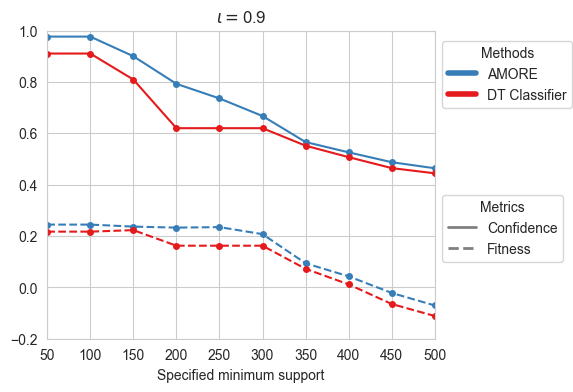

In [25]:
## Need grid search first to get the results with different minimum supports

if grid_search:
    
    cf_mtx = np.vstack([config_metric_records[key]["top_confidence_records"] for key in config_metric_records.keys()])
    ft_mtx = np.vstack([config_metric_records[key]["top_fitness_records"] for key in config_metric_records.keys()])
    
    DT_cf_mtx = np.vstack([DT_config_metric_records[key]["top_confidence_records"] for key in DT_config_metric_records.keys()])
    DT_ft_mtx = np.vstack([DT_config_metric_records[key]["top_fitness_records"] for key in DT_config_metric_records.keys()])
    
    eutils.plot_confidence_fitness_curve(cf_mtx,ft_mtx,DT_cf_mtx,DT_ft_mtx,support_range,save_path="./AhR",y_lim=[-0.2,1.],confidence_lower_bound=confidence_lower_bound)